In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy
import pandas as pd

# Set DeepXDE backend, we could use tensorflow, jax or paddle instead
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Increasing floating point precision
dde.config.set_default_float('float64')

# For experiments reproductibility
dde.config.set_random_seed(42)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


## SIR Model

$$
\frac{dS}{dt} = −βSI
$$
$$
\frac{dI}{dt} = βSI − γI
$$
$$
\frac{dR}{dt} = γI.
$$


In [31]:

df = pd.read_csv("../data/covid-es-2021.csv", encoding="latin-1", sep=",")

df = df[df["Evolucao"].isin(["Cura", "Óbito pelo COVID-19"])]

df["NotificationDate"] = df["DataNotificacao"]
df["DeathDate"] = df["DataObito"]
df["RecoveryDate"] = df.apply(lambda row: row["DataEncerramento"] if row["Evolucao"] == "Cura" else None, axis=1)

df["NotificationDate"] = pd.to_datetime(df["NotificationDate"], format='%Y-%m-%d')
df["DeathDate"] = pd.to_datetime(df["DeathDate"], format='%Y-%m-%d')
df["RecoveryDate"] = pd.to_datetime(df["RecoveryDate"], format='%Y-%m-%d')


df = df[df["RecoveryDate"] >= df["NotificationDate"]]


In [42]:

date_range = pd.date_range(
    start=df['NotificationDate'].min(),
    end=max(df['RecoveryDate'].max(), df['DeathDate'].max()),
    freq='D'
)

# Initialize SIR DataFrame
sir = pd.DataFrame(index=date_range, columns=['S', 'I', 'R'])

pd.set_option('future.no_silent_downcasting', True)
sir = sir.fillna(0)

# Track daily active and removed cases
for i, row in df.iterrows():
    
    # Active from notification until recovery/death
    start = row['NotificationDate']
    end = row['RecoveryDate'] if pd.notna(row['RecoveryDate']) else row['DeathDate']
    
    if pd.isna(end):  # Case is still active (no recovery/death)
        sir.loc[start:, 'I'] += 1
    else:  # Case becomes removed on recovery/death date
        assert start <= end, f"Inconsistency at row {i}, start={start}, end={end}, death={row["DeathDate"]}, rec={row["RecoveryDate"]}"
        sir.loc[start:end - pd.Timedelta(days=1), 'I'] += 1
        sir.loc[end:, 'R'] += 1

TOTAL_POPULATION = 342800  # 2023 Census
sir['S'] = TOTAL_POPULATION - sir['I'] - sir['R']


In [43]:
sir.head()

,S,I,R
2021-01-01,342113,685,2
2021-01-02,341179,1617,4
2021-01-03,340323,2461,16
2021-01-04,337533,5162,105
2021-01-05,335257,7287,256


In [ ]:
# Parameters
t0, tf = 0, sir.shape[0]

S0 = sir.iloc[0, sir.columns.get_loc("S")]
I0 = sir.iloc[0, sir.columns.get_loc("I")]
R0 = sir.iloc[0, sir.columns.get_loc("R")]

In [ ]:
# Leranable external parameters
beta = dde.Variable(0.5)
gamma = dde.Variable(0.5)

In [ ]:
sir["t"] = (sir["date"] - df["date"].min()).dt.days

In [28]:
# Solving the model

def sir_model(t, y):

    S, I, R = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    dS_dt = dde.grad.jacobian(y, t, i=0)
    dI_dt = dde.grad.jacobian(y, t, i=1)
    dR_dt = dde.grad.jacobian(y, t, i=2)
    
    return [
        dS_dt - (-beta * S * I),
        dI_dt - (beta * S * I - gamma * I),
        dR_dt - (gamma * I)   
    ]

geom = dde.geometry.TimeDomain(t0, tf)

ic_S = dde.icbc.IC(geom, lambda _: S0, lambda _, on_initial: on_initial, component=0)
ic_I = dde.icbc.IC(geom, lambda _: I0, lambda _, on_initial: on_initial, component=1)
ic_R = dde.icbc.IC(geom, lambda _: R0, lambda _, on_initial: on_initial, component=2)

data = dde.data.PDE(
    geom, 
    sir_model, 
    [ic_S, ic_I, ic_R],
    num_domain=100, 
    num_boundary=2)

net = dde.nn.FNN([1] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=0.001,  external_trainable_variables=[beta, gamma])


Compiling model...
'compile' took 0.982501 s



Compiling model...
'compile' took 0.000944 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
40000     [2.28e-06, 1.11e-06, 5.06e-06, 1.87e-07, 1.36e-07, 1.03e-07]    [2.28e-06, 1.11e-06, 5.06e-06, 1.87e-07, 1.36e-07, 1.03e-07]    []  
41000     [1.35e-06, 6.70e-07, 3.48e-06, 5.00e-07, 6.49e-09, 1.20e-07]    [1.35e-06, 6.70e-07, 3.48e-06, 5.00e-07, 6.49e-09, 1.20e-07]    []  
42000     [4.10e-08, 7.83e-08, 1.36e-08, 5.23e-10, 1.63e-10, 4.31e-10]    [4.10e-08, 7.83e-08, 1.36e-08, 5.23e-10, 1.63e-10, 4.31e-10]    []  
43000     [4.35e-07, 2.46e-07, 9.88e-07, 3.24e-07, 1.41e-08, 1.52e-07]    [4.35e-07, 2.46e-07, 9.88e-07, 3.24e-07, 1.41e-08, 1.52e-07]    []  
44000     [3.79e-08, 6.26e-08, 9.30e-09, 1.25e-10, 1.03e-09, 2.40e-09]    [3.79e-08, 6.26e-08, 9.30e-09, 1.25e-10, 1.03e-09, 2.40e-09]    []  
45000     [1.99e-07, 9.95e-07, 7.43e-08, 2.38e-10, 9.18e-11, 1.76e-14]

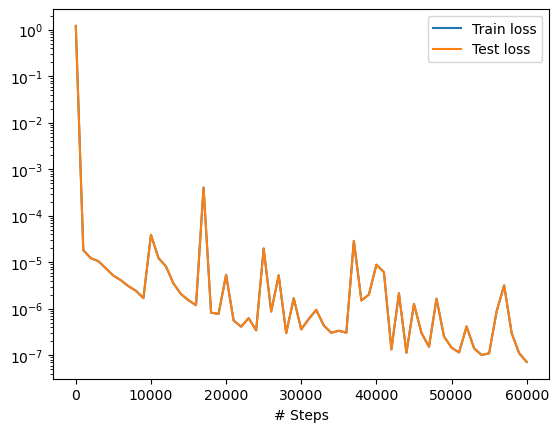

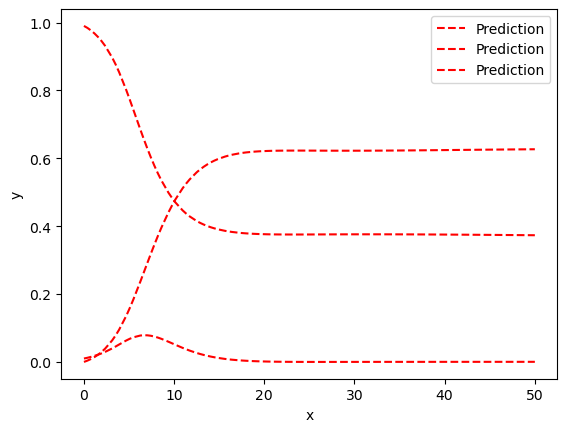

In [9]:

losshistory, train_state = model.train(iterations=20000, model_save_path="../models/sir")

dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [14]:

model.restore("../models/sir-20000.pt")

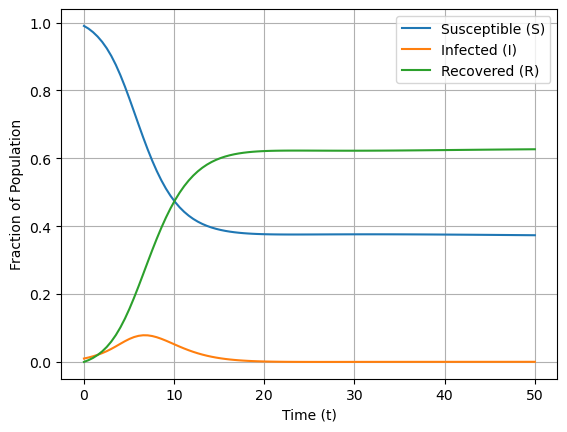

In [15]:
t = np.linspace(t0, tf, 100)
y_pred = model.predict(t.reshape(-1, 1))
S_pred, I_pred, R_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

plt.plot(t, S_pred, label="Susceptible (S)")
plt.plot(t, I_pred, label="Infected (I)")
plt.plot(t, R_pred, label="Recovered (R)")
plt.xlabel("Time (t)")
plt.ylabel("Fraction of Population")
plt.legend()
plt.grid()
plt.savefig("../figures/sir_pinns.png")
plt.show()

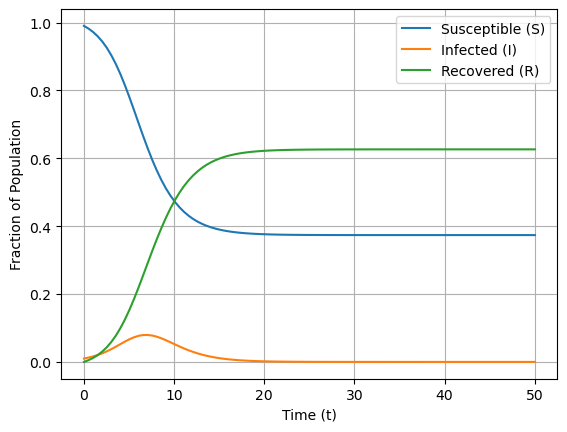

In [17]:
#método Runge Kutta para o modelo SIR

import numpy as np
import matplotlib.pyplot as plt

# Modelo SIR: dS/dt = -β S I, dI/dt = β S I - μ I, dR/dt = μ I
def sir_model(y, t, beta, mu):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - mu * I
    dRdt = mu * I
    return np.array([dSdt, dIdt, dRdt])

# Implementação do método RK4
def rk4(f, y0, t, beta, mu):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        dt = t[i+1] - t[i]
        k1 = f(y[i], t[i], beta, mu)
        k2 = f(y[i] + dt * k1 / 2, t[i] + dt / 2, beta, mu)
        k3 = f(y[i] + dt * k2 / 2, t[i] + dt / 2, beta, mu)
        k4 = f(y[i] + dt * k3, t[i] + dt, beta, mu)
        y[i+1] = y[i] + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

    return y

# Parâmetros do modelo
beta = 1.4    # Taxa de transmissão
mu = 0.9      # Taxa de recuperação

# Condições iniciais
S0, I0, R0 = 0.99, 0.01, 0  # 99% suscetíveis, 1% infectados, 0% recuperados
y0 = np.array([S0, I0, R0])

# Intervalo de tempo
t = np.linspace(0, 50, 100)  # De 0 a 50, com 100 pontos

# Resolver o sistema SIR com RK4
sol = rk4(sir_model, y0, t, beta, mu)

# Separar as soluções
S, I, R = sol[:, 0], sol[:, 1], sol[:, 2]

# Plotar os resultados
plt.plot(t, S, label="Susceptible (S)")
plt.plot(t, I, label="Infected (I)")
plt.plot(t, R, label="Recovered (R)")
plt.xlabel("Time (t)")
plt.ylabel("Fraction of Population")
plt.legend()
plt.grid()
plt.savefig("../figures/sir_rk4.png")
plt.show()